<a href="https://colab.research.google.com/github/ovbystrova/Interference/blob/master/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/ovbystrova/Interference/raw/master/data/original_texts.csv

--2020-03-26 19:23:39--  https://github.com/ovbystrova/Interference/raw/master/data/original_texts.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ovbystrova/Interference/master/data/original_texts.csv [following]
--2020-03-26 19:23:39--  https://raw.githubusercontent.com/ovbystrova/Interference/master/data/original_texts.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18891291 (18M) [text/plain]
Saving to: ‘original_texts.csv’

original_texts.csv  100%[===================>]  18.02M   117MB/s    in 0.2s    

2020-03-26 19:23:40 (117 MB/s) - ‘original_texts.csv’ saved [18891291/18891291]



In [2]:
!pip install pymorphy2

     |████████████████████████████████| 51kB 2.0MB/s 
     |████████████████████████████████| 7.1MB 6.5MB/s 


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymorphy2
import re
import sklearn

from gensim.models import FastText
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm

In [0]:
SEED = 42

In [0]:
results = pd.DataFrame(columns=['model', 'preprocess', 'vectorize', 'score', 'native', 'language_background'])

In [6]:
results.columns

Index(['model', 'preprocess', 'vectorize', 'score', 'native',
       'language_background'],
      dtype='object')

In [0]:
def add_row(results_df, res_list):
  return results_df.append(dict(zip(results_df.columns, res_list)), ignore_index=True)

# THE BASELINE RESULTS ARE AS FOLLOWS

**F1 score**

![image](https://github.com/ovbystrova/Interference/raw/master/f1.png)

**Accuracy score**

![image](https://github.com/ovbystrova/Interference/raw/master/acc.png)



## Dataset

In [0]:
df = pd.read_csv('original_texts.csv', index_col='id')

In [9]:
df.head()

,native,language_background,title,text,date1,date2,level,annotated,checked
id,,,,,,,,,
1,eng,HL,"expository (non-timed, paragraph, Environmenta...",Загрязнение тяжелыми металлами Дальнегорского...,2009.0,2010.0,AM,1,1
2,NaN,NaN,–,Многие жители России пишут письма президенту М...,2000.0,2013.0,NaN,1,1
3,eng,HL,"business correspondence (non-timed, paragraph,...",Директору магазина « Адидас» М. И. Васильченк...,2009.0,2010.0,AM,1,1
4,eng,FL,"definition (non-timed, sentences, Russian in t...",&lt; Что такое аннотация?&gt;. Что такое анно...,2011.0,2012.0,IH,1,1
5,eng,FL,"summary (non-timed, paragraph, Capstone)","Вывод. Спасибо, ребята, за хорошие ответы. Я ...",2012.0,2013.0,AM,1,1


Drop useless for our task columns and NaNs

In [0]:
df = df.drop(['title', 'date1', 'date2', 'level', 'annotated', 'checked'], axis=1)
df = df.dropna()

In [11]:
df['text'] = df.text.apply(lambda x: re.sub('\&[lg]t;', '', x))
df.head()

,native,language_background,text
id,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...
4,eng,FL,Что такое аннотация?. Что такое аннотация ( ...
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ..."
6,eng,FL,Записи. Первая проблема- что производить? втор...


In [12]:
df['native'].value_counts(normalize=True)

eng    0.401660
jap    0.200639
fin    0.157216
fr     0.063218
kaz    0.063091
ger    0.036143
kor    0.025160
swe    0.022733
ita    0.014687
taj    0.003831
nor    0.003576
chi    0.003065
ser    0.002427
dut    0.002299
est    0.000255
Name: native, dtype: float64

In [13]:
le = LabelEncoder()
le.fit(df.native.values)
list(le.classes_)
df['target_native'] = le.transform(df['native'].values)
df.head()

,native,language_background,text,target_native
id,,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...,2
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...,2
4,eng,FL,Что такое аннотация?. Что такое аннотация ( ...,2
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ...",2
6,eng,FL,Записи. Первая проблема- что производить? втор...,2


In [0]:
# list(le.inverse_transform([2, 2, 1])))

In [15]:
df['language_background'].value_counts(normalize=True)

FL    0.689144
HL    0.310856
Name: language_background, dtype: float64

In [16]:
le_lb = LabelEncoder()
le_lb.fit(df.language_background.values)
list(le_lb.classes_)
df['target_lb'] = le_lb.transform(df['language_background'].values)
df.head()

,native,language_background,text,target_native,target_lb
id,,,,,
1,eng,HL,Загрязнение тяжелыми металлами Дальнегорского...,2,1
3,eng,HL,Директору магазина « Адидас» М. И. Васильченк...,2,1
4,eng,FL,Что такое аннотация?. Что такое аннотация ( ...,2,0
5,eng,FL,"Вывод. Спасибо, ребята, за хорошие ответы. Я ...",2,0
6,eng,FL,Записи. Первая проблема- что производить? втор...,2,0


## TF-IDF

### on text

#### native

In [0]:
vec = TfidfVectorizer(lowercase=True, tokenizer=None, analyzer='word', stop_words='english', 
                      ngram_range=(1,3), max_df=0.9, min_df=10, 
                      use_idf=True, smooth_idf=True, norm='l2')

xs = vec.fit_transform(df['text'])
ys_n = df.target_native.values
ys_lb = df.target_lb.values

In [0]:
x_train, x_test, y_train_n, y_test_n = train_test_split(xs, ys_n,
                                                    test_size=0.2,
                                                    random_state=SEED,
                                                    stratify=ys_n)

In [19]:
%%time

model_n = LogisticRegressionCV(Cs=[10, 1, 0.1], cv=3, penalty='l2', 
                             multi_class='multinomial',
                             scoring='f1_macro', n_jobs=-1, verbose=True, random_state=SEED)
model_n.fit(x_train, y_train_n)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.6s finished


CPU times: user 19.8 s, sys: 33.1 s, total: 52.9 s
Wall time: 42.1 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [20]:
y_pred_n = model_n.predict(x_test)
metrics.f1_score(y_test_n, y_pred_n, average='macro')

0.5813428627511351

In [21]:
metrics.accuracy_score(y_test_n, y_pred_n)

0.8659003831417624

#### language background


In [0]:
x_train, x_test, y_train_lb, y_test_lb = train_test_split(xs, ys_lb,
                                                    test_size=0.2,
                                                    random_state=SEED,
                                                    stratify=ys_lb)

In [23]:
%%time

model_lb = LogisticRegressionCV(Cs=[10, 1, 0.1], cv=3, penalty='l2', 
                             multi_class='multinomial',
                             scoring='f1_macro', n_jobs=-1, verbose=True, random_state=SEED)
model_lb.fit(x_train, y_train_lb)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished


CPU times: user 4.22 s, sys: 7.39 s, total: 11.6 s
Wall time: 6.4 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [24]:
y_pred_lb = model_lb.predict(x_test)
metrics.f1_score(y_test_lb, y_pred_lb, average='macro')

0.8679522554098691

In [25]:
metrics.accuracy_score(y_test_lb, y_pred_lb)

0.8895274584929758

#### add results

In [26]:
results = add_row(results, ['logreg', None, 'tf-idf', 'f1', metrics.f1_score(y_test_n, y_pred_n, average='macro'), metrics.f1_score(y_test_lb, y_pred_lb, average='macro')])
results = add_row(results, ['logreg', None, 'tf-idf', 'accuracy', metrics.accuracy_score(y_test_n, y_pred_n), metrics.accuracy_score(y_test_lb, y_pred_lb)])
results

,model,preprocess,vectorize,score,native,language_background
0,logreg,None,tf-idf,f1,0.581343,0.867952
1,logreg,None,tf-idf,accuracy,0.865900,0.889527


### on tokenized

#### native

In [0]:
tokenize = lambda x: re.findall('\w+', x.lower())

In [0]:
vec2 = TfidfVectorizer(lowercase=True, tokenizer=tokenize, analyzer='word', 
                      ngram_range=(1,3), max_df=0.9, min_df=10, 
                      use_idf=True, smooth_idf=True, norm='l2')
xs_token = vec2.fit_transform(df['text'])

In [0]:
x_train_token, x_test_token, y_train_n, y_test_n = train_test_split(xs_token, ys_n,
                                                    test_size=0.2,
                                                    random_state=SEED,
                                                    stratify=ys_n)

In [30]:
%%time
fi = LogisticRegression(C=1, penalty='l1', solver='saga', multi_class='multinomial', n_jobs=-1, random_state=SEED)


model_token_n = make_pipeline(
    SelectFromModel(fi, threshold="mean", max_features=20000),
    LogisticRegressionCV(Cs=[10, 1, 0.1], cv=3, penalty='l2', 
                             multi_class='multinomial',
                             scoring='f1_macro', n_jobs=-1, verbose=True, random_state=SEED)
)
model_token_n.fit(x_train_token, y_train_n)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished


CPU times: user 20.9 s, sys: 22.7 ms, total: 21 s
Wall time: 24.3 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [31]:
y_pred_token_n = model_token_n.predict(x_test_token)
metrics.f1_score(y_test_n, y_pred_token_n, average='macro')

0.4773317920457982

In [32]:
metrics.accuracy_score(y_test_n, y_pred_token_n)

0.8218390804597702

#### language background

In [0]:
x_train_token, x_test_token, y_train_lb, y_test_lb = train_test_split(xs_token, ys_lb,
                                                    test_size=0.2,
                                                    random_state=SEED,
                                                    stratify=ys_lb)

In [34]:
%%time
fi = LogisticRegression(C=1, penalty='l1', solver='saga', multi_class='multinomial', n_jobs=-1, random_state=SEED)


model_token_lb = make_pipeline(
    SelectFromModel(fi, threshold="mean", max_features=20000),
    LogisticRegressionCV(Cs=[10, 1, 0.1], cv=3, penalty='l2', 
                             multi_class='multinomial',
                             scoring='f1_macro', n_jobs=-1, verbose=True, random_state=SEED)
)
model_token_lb.fit(x_train_token, y_train_lb)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


CPU times: user 5.36 s, sys: 5.41 ms, total: 5.37 s
Wall time: 6.03 s


In [35]:
y_pred_token_lb = model_token_lb.predict(x_test_token)
metrics.f1_score(y_test_lb, y_pred_token_lb, average='macro')

0.7913515555864894

In [36]:
metrics.accuracy_score(y_test_lb, y_pred_token_lb)

0.8288633461047255

#### add results

In [37]:
results = add_row(results, ['logreg search', 'regex tokens', 'tf-idf', 'f1', metrics.f1_score(y_test_n, y_pred_token_n, average='macro'), metrics.f1_score(y_test_lb, y_pred_token_lb, average='macro')])
results = add_row(results, ['logreg search', 'regex tokens', 'tf-idf', 'accuracy', metrics.accuracy_score(y_test_n, y_pred_token_n), metrics.accuracy_score(y_test_lb, y_pred_token_lb)])
results

,model,preprocess,vectorize,score,native,language_background
0,logreg,None,tf-idf,f1,0.581343,0.867952
1,logreg,None,tf-idf,accuracy,0.865900,0.889527
2,logreg search,regex tokens,tf-idf,f1,0.477332,0.791352
3,logreg search,regex tokens,tf-idf,accuracy,0.821839,0.828863


## w2v

In [0]:
morph=pymorphy2.MorphAnalyzer()
def lemmatize(tokens):
  return [morph.parse(word)[0].normal_form for word in tokens]

In [0]:
df['tokens'] = df['text'].apply(tokenize)

In [0]:
df['lemmas'] = df['tokens'].apply(lemmatize)

In [41]:
!wget http://vectors.nlpl.eu/repository/20/187.zip

--2020-03-26 19:31:17--  http://vectors.nlpl.eu/repository/20/187.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.225
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.225|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2692389554 (2.5G) [application/zip]
Saving to: ‘187.zip’

187.zip             100%[===================>]   2.51G  21.7MB/s    in 2m 9s   

2020-03-26 19:33:27 (19.9 MB/s) - ‘187.zip’ saved [2692389554/2692389554]



In [42]:
!unzip 187.zip

Archive:  187.zip
  inflating: meta.json               
  inflating: model.model             
  inflating: model.model.vectors_ngrams.npy  
  inflating: model.model.vectors.npy  
  inflating: model.model.vectors_vocab.npy  
  inflating: README                  


In [45]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load('model.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [66]:
wv['вошь'][-10:]

array([ 1.4980615 , -1.4640915 , -0.8392372 ,  2.1419618 , -0.69687366,
        1.9414659 , -0.91928923,  0.9815347 , -1.0415771 ,  0.87714154],
      dtype=float32)

In [0]:
bad = 0
total = 0
def vectorize(sent, w):
  sent_vec = []
  for w in sent:
    global total 
    total += 1
    try:
      vec = wv.wv[w]
      sent_vec.append(vec)
    except KeyError:
      continue
    except AttributeError:
      global bad 
      bad += 1
  if sent_vec:
    return np.mean(np.array(sent_vec), axis=0)
  else:
    return np.zeros(300)

In [68]:
df['vec'] = df['lemmas'].apply(lambda text: vectorize(text, wv))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


In [70]:
bad/total

0.17448897338300362

In [0]:
xs_vec = np.vstack(df.vec.values)

#### native

In [0]:
x_train_vec, x_test_vec, y_train_n, y_test_n = train_test_split(xs_vec, ys_n,
                                                    test_size=0.2,
                                                    random_state=SEED,
                                                    stratify=ys_n)

In [73]:
%%time
fi = LogisticRegression(C=1, penalty='l1', solver='saga', multi_class='multinomial', n_jobs=-1, random_state=SEED)


model_vec_n = make_pipeline(
    SelectFromModel(fi, threshold="mean", max_features=300),
    LogisticRegressionCV(Cs=[10, 1, 0.1], cv=3, penalty='l2', 
                             multi_class='multinomial',
                             scoring='f1_macro', n_jobs=-1, verbose=True, random_state=SEED)
)
model_vec_n.fit(x_train_vec, y_train_n)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.4s finished


CPU times: user 36.2 s, sys: 3.37 s, total: 39.6 s
Wall time: 39.7 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [74]:
y_pred_vec_n = model_vec_n.predict(x_test_vec)
metrics.f1_score(y_test_n, y_pred_vec_n, average='macro')

0.5241299992944873

In [75]:
metrics.accuracy_score(y_test_n, y_pred_vec_n)

0.7790549169859514

#### language background

In [0]:
x_train_vec, x_test_vec, y_train_lb, y_test_lb = train_test_split(xs_vec, ys_lb,
                                                    test_size=0.2,
                                                    random_state=SEED,
                                                    stratify=ys_lb)

In [77]:
%%time
fi = LogisticRegression(C=1, penalty='l1', solver='saga', multi_class='multinomial', n_jobs=-1, random_state=SEED)


model_vec_lb = make_pipeline(
    SelectFromModel(fi, threshold="mean", max_features=300),
    LogisticRegressionCV(Cs=[10, 1, 0.1], cv=3, penalty='l2', 
                             multi_class='multinomial',
                             scoring='f1_macro', n_jobs=-1, verbose=True, random_state=SEED)
)
model_vec_lb.fit(x_train_vec, y_train_lb)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished


CPU times: user 6.54 s, sys: 716 ms, total: 7.26 s
Wall time: 7.56 s


In [78]:
y_pred_vec_lb = model_vec_lb.predict(x_test_vec)
metrics.f1_score(y_test_lb, y_pred_vec_lb, average='macro')

0.720226911403382

In [79]:
metrics.accuracy_score(y_test_lb, y_pred_vec_lb)

0.7726692209450831

#### add results

In [80]:
results = add_row(results, ['logreg search', 'regex tokens', 'w2v bow mean', 'f1', metrics.f1_score(y_test_n, y_pred_vec_n, average='macro'), metrics.f1_score(y_test_lb, y_pred_vec_lb, average='macro')])
results = add_row(results, ['logreg search', 'regex tokens', 'w2v bow mean', 'accuracy', metrics.accuracy_score(y_test_n, y_pred_vec_n), metrics.accuracy_score(y_test_lb, y_pred_vec_lb)])
results

,model,preprocess,vectorize,score,native,language_background
0,logreg,None,tf-idf,f1,0.581343,0.867952
1,logreg,None,tf-idf,accuracy,0.865900,0.889527
2,logreg search,regex tokens,tf-idf,f1,0.477332,0.791352
3,logreg search,regex tokens,tf-idf,accuracy,0.821839,0.828863
4,logreg search,regex tokens,w2v bow mean,f1,0.524130,0.720227
5,logreg search,regex tokens,w2v bow mean,accuracy,0.779055,0.772669


## neural network

In [82]:
!nvidia-smi

Thu Mar 26 19:48:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else tt.device('cpu')

### raw text

In [0]:
class RawTextModel(nn.Module):
    
    def __init__(self, embed_size, hidden_size, out_size):
        super(RawTextModel, self).__init__()
        self.fc_hidden = nn.Linear(embed_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size)
        self.soft = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc_hidden(x.float())
        x = self.fc_out(x)
        return x

In [0]:
def train_epoch(data_iter, len_iter, n_epoch, model, criterion, optimizer=None):
    train_losses = []
    total_loss = 0
    data_iter = tqdm(data_iter, total=len_iter, desc=f"Epoch {n_epoch + 1}", leave=True)
    counter = 0
    for batch in data_iter:
        if optimizer:
          optimizer.zero_grad()
        pred = model.forward(batch.vec)
        loss = criterion(pred, batch.tgt)
        loss.backward()
        if optimizer:
          optimizer.step()
        loss_value = loss.detach().item()
        total_loss += loss_value
        train_losses.append(loss_value)
        data_iter.set_postfix(loss = loss_value)
        counter += 1
        
    total_loss /= counter
    return total_loss, train_losses


def valid_epoch(data_iter, len_iter, n_epoch, model, criterion):
    valid_losses = []
    total_loss = 0
    data_iter = tqdm(data_iter, total=len_iter, desc=f"Eval epoch {n_epoch + 1}", leave=True)
    counter = 0
    for batch in data_iter:
        with torch.no_grad():
            pred = model.forward(batch.vec)
            loss = criterion(pred, batch.tgt)
            loss_value = loss.detach().item()
            total_loss += loss_value
            valid_losses.append(loss_value)
            data_iter.set_postfix(loss = loss_value)
            counter +=1
        
    total_loss /= counter
    return total_loss, valid_losses

def test_model(data_iter, len_iter, model, criterion):
    accs = []
    f1s = []
    model.eval()
    with torch.no_grad():
      data_iter = tqdm(data_iter, total=len_iter, desc=f"Test", leave=True)
      for batch in data_iter:
        pred = model.forward(batch.vec)
        pred = torch.argmax(pred.detach(), axis=1).cpu()
        tgt = batch.tgt.cpu()
        acc = metrics.accuracy_score(pred, tgt)
        accs.append(acc)
        f1 = metrics.f1_score(pred, tgt, average='macro')
        f1s.append(f1)
    return np.mean(accs), np.mean(f1s)

In [0]:
def train_model(model, num_epochs, trn_itr, len_train, vld_itr, len_valid, criterion, optimizer):
  total_train_losses = []
  total_valid_losses = []
  for epoch in range(num_epochs):
      model.train()
      loss, train_losses = train_epoch(trn_itr, len_train, epoch, model, criterion, optimizer)
      total_train_losses += train_losses
      print('train loss', loss)
      
      model.eval()
      with torch.no_grad():
          loss, valid_losses = valid_epoch(vld_itr, len_valid, epoch, model, criterion)
          total_valid_losses += valid_losses
          print('valid loss', loss)
  return total_train_losses, total_valid_losses

In [0]:
def plot_smooth_losses(total_train_losses, total_valid_losses, sigma=10):
  smooth = lambda y: gaussian_filter1d(y, sigma=sigma)
  plt.figure(figsize=(14, 10))
  plt.plot(range(len(total_train_losses)), smooth(total_train_losses), np.array(range(len(total_valid_losses)))*(len(total_train_losses)/len(total_valid_losses)), smooth(total_valid_losses))
  plt.legend(('train loss', 'valid loss by batch'),
            loc='center', prop={'size': 18})
  plt.title('Smoothed training process', fontsize=20)
  plt.xlabel('Iterations', fontsize=16)
  plt.ylabel('Loss function (smoothed)', fontsize=16)
  plt.show()

##### batches

In [0]:
batch_size = 128

In [168]:
n_df = df[['target_native', 'vec']]
n_df['target'] = n_df['target_native']
n_df = n_df.drop(['target_native'], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
train_df, test_df = train_test_split(n_df, test_size=0.2, random_state=SEED, stratify=n_df.target.values)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=train_df.target.values)

In [0]:
class Batch:
  def __init__(self, vectors, targets):
    self.vec = vectors
    self.tgt = targets

In [0]:
class Iterator:
  def __init__(self, df, batch_size=128, device='cpu'):
    self.batches = self.make_batches(df, batch_size, device)

  @staticmethod
  def make_batches(df, batch_size, device):
    batches = []
    shuffled = df.sample(frac=1)
    i = 0
    while i < len(df):
      b = shuffled[i: i+batch_size]
      if len(b) == batch_size:
        vec = torch.tensor(list(b.vec.values)).to(device)
        tgt = torch.tensor(list(b.target.values)).to(device)
        batch = Batch(vec, tgt)
        batches.append(batch)
      i += batch_size
    return batches

In [0]:
trn_itr = Iterator(train_df, batch_size=batch_size, device=DEVICE).batches
vld_itr = Iterator(val_df, batch_size=batch_size, device=DEVICE).batches
tst_itr = Iterator(test_df, batch_size=batch_size, device=DEVICE).batches

In [0]:
len_train = len(trn_itr)
len_valid = len(vld_itr)
len_test = len(tst_itr)

#### native

In [0]:
torch.cuda.empty_cache()

model = RawTextModel(embed_size=len(wv['мышь']),
                hidden_size=128,
                out_size = len(np.unique(df.native.values)))

optimizer = optim.Adam(model.parameters(), lr=0.02)
criterion = nn.CrossEntropyLoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [173]:
num_epochs = 5
total_train_losses, total_valid_losses = train_model(model, num_epochs, trn_itr, len_train, vld_itr, len_valid, criterion, optimizer)


train loss 2.015321311278221



valid loss 1.0429477956559923



train loss 0.9425239562988281



valid loss 0.921096940835317



train loss 0.8490091409438696



valid loss 0.9044847753312852



train loss 0.7954741395436801



valid loss 0.9204485085275438



train loss 0.7452272910338181



valid loss 0.913093990749783


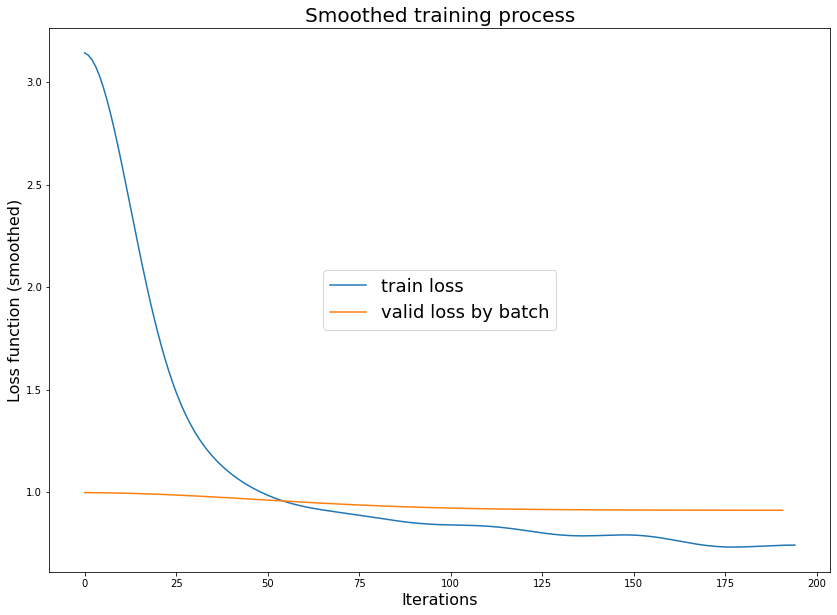

In [174]:
plot_smooth_losses(total_train_losses, total_valid_losses)

In [175]:
n_acc, n_f1 = test_model(tst_itr, len_test, model, criterion)
n_acc, n_f1

(0.7063802083333334, 0.4418964507341692)

#### language background

In [176]:
lb_df = df[['target_lb', 'vec']]
lb_df['target'] = lb_df['target_lb']
lb_df = lb_df.drop(['target_lb'], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
lb_train_df, lb_test_df = train_test_split(lb_df, test_size=0.2, random_state=SEED, stratify=lb_df.target.values)
lb_train_df, lb_val_df = train_test_split(lb_train_df, test_size=0.2, random_state=SEED, stratify=lb_train_df.target.values)

In [0]:
lb_trn_itr = Iterator(lb_train_df, batch_size=batch_size, device=DEVICE).batches
lb_vld_itr = Iterator(lb_val_df, batch_size=batch_size, device=DEVICE).batches
lb_tst_itr = Iterator(lb_test_df, batch_size=batch_size, device=DEVICE).batches

In [0]:
lb_len_train = len(lb_trn_itr)
lb_len_valid = len(lb_vld_itr)
lb_len_test = len(lb_tst_itr)

In [0]:
torch.cuda.empty_cache()

lb_model = RawTextModel(embed_size=len(wv['мышь']),
                hidden_size=128,
                out_size = len(np.unique(df.language_background.values)))

optimizer = optim.Adam(model.parameters(), lr=0.02)
criterion = nn.CrossEntropyLoss()

lb_model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [184]:
num_epochs = 5
total_train_losses, total_valid_losses = train_model(lb_model, num_epochs, lb_trn_itr, lb_len_train, lb_vld_itr, lb_len_valid, criterion, optimizer)


train loss 1.3030679317621083



valid loss 0.5786994099617004



train loss 0.6455787244515542



valid loss 0.5285495883888669



train loss 0.5510231378750924



valid loss 0.6465576820903354



train loss 0.5030133028825124



valid loss 0.5057934522628784



train loss 0.470683318682206



valid loss 0.503674199183782


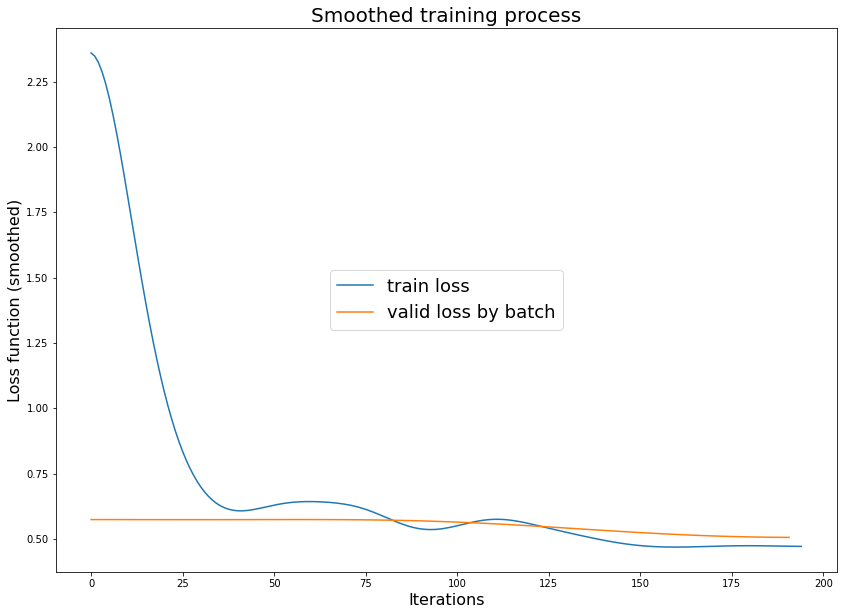

In [185]:
plot_smooth_losses(total_train_losses, total_valid_losses)

In [186]:
lb_acc, lb_f1 = test_model(lb_tst_itr, lb_len_test, lb_model, criterion)
lb_acc, lb_f1

(0.7578125, 0.6779243910552072)

In [187]:
results = add_row(results, ['1 linear nn', 'regex tokens + lemmas', 'w2v bow mean', 'f1', n_f1, lb_f1])
results = add_row(results, ['1 linear nn', 'regex tokens + lemmas', 'w2v bow mean', 'accuracy', n_acc, lb_acc])
results

,model,preprocess,vectorize,score,native,language_background
0,logreg,None,tf-idf,f1,0.581343,0.867952
1,logreg,None,tf-idf,accuracy,0.865900,0.889527
2,logreg search,regex tokens,tf-idf,f1,0.477332,0.791352
3,logreg search,regex tokens,tf-idf,accuracy,0.821839,0.828863
4,logreg search,regex tokens,w2v bow mean,f1,0.524130,0.720227
5,logreg search,regex tokens,w2v bow mean,accuracy,0.779055,0.772669
6,1 linear nn,regex tokens + lemmas,w2v bow mean,f1,0.441896,0.677924
7,1 linear nn,regex tokens + lemmas,w2v bow mean,accuracy,0.706380,0.757812


In [188]:
results.style.background_gradient(axis=0, cmap='Reds')

,model,preprocess,vectorize,score,native,language_background
0,logreg,None,tf-idf,f1,0.581343,0.867952
1,logreg,None,tf-idf,accuracy,0.8659,0.889527
2,logreg search,regex tokens,tf-idf,f1,0.477332,0.791352
3,logreg search,regex tokens,tf-idf,accuracy,0.821839,0.828863
4,logreg search,regex tokens,w2v bow mean,f1,0.52413,0.720227
5,logreg search,regex tokens,w2v bow mean,accuracy,0.779055,0.772669
6,1 linear nn,regex tokens + lemmas,w2v bow mean,f1,0.441896,0.677924
7,1 linear nn,regex tokens + lemmas,w2v bow mean,accuracy,0.70638,0.757812


In [190]:
results[results['score'] == 'f1'].style.background_gradient(axis=0, cmap='Reds')

,model,preprocess,vectorize,score,native,language_background
0,logreg,None,tf-idf,f1,0.581343,0.867952
2,logreg search,regex tokens,tf-idf,f1,0.477332,0.791352
4,logreg search,regex tokens,w2v bow mean,f1,0.52413,0.720227
6,1 linear nn,regex tokens + lemmas,w2v bow mean,f1,0.441896,0.677924


In [191]:
results[results['score'] == 'accuracy'].style.background_gradient(axis=0, cmap='Reds')

,model,preprocess,vectorize,score,native,language_background
1,logreg,None,tf-idf,accuracy,0.8659,0.889527
3,logreg search,regex tokens,tf-idf,accuracy,0.821839,0.828863
5,logreg search,regex tokens,w2v bow mean,accuracy,0.779055,0.772669
7,1 linear nn,regex tokens + lemmas,w2v bow mean,accuracy,0.70638,0.757812
